In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

Thu Sep 15 12:27:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import gc
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import re
import html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, SGD, AdamW, RAdam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,GroupKFold
from sklearn.metrics import log_loss,f1_score

from transformers import AutoModel, AutoConfig, AutoTokenizer, AdamW, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup


from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
import catboost as ctb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DIR = '/content/drive/MyDrive/Competitions/Signate/MUFJ'
INPUT_DIR = os.path.join(DIR,'input')
OUTPUT_DIR = os.path.join(DIR,'output')
OUTPUT_SUB_DIR = os.path.join(OUTPUT_DIR,'submission')
#OUTPUT_MODEL_DIR = os.path.join(OUTPUT_DIR,'model')
OUTPUT_MODEL_DIR = DIR + '/output/model/EXP21/'
if not os.path.exists(OUTPUT_MODEL_DIR):
    os.makedirs(OUTPUT_MODEL_DIR)

In [ ]:
class CFG:
    num_workers=4
    path=OUTPUT_MODEL_DIR
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True

In [ ]:
def get_score(labels, outputs):
    thresh = 0.5
    y_pred = outputs
    y_true = labels
    return f1_score(y_true, (y_pred>thresh).astype(int))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_logger(filename=OUTPUT_MODEL_DIR+'train'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG.seed)

In [ ]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters

def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """
    
    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"
        
        if hasattr(embeddings_path, attr_name): 
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

In [ ]:
oof_df = pd.read_pickle(CFG.path+'oof_df.pkl')
labels = oof_df['state'].values
preds = oof_df['pred'].values
score = get_score(labels, preds)
LOGGER.info(f'CV Score: {score:<.4f}')

CV Score: 0.8079
INFO:__main__:CV Score: 0.8079


In [ ]:
train = pd.read_csv(os.path.join(INPUT_DIR,'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR,'test.csv'))
sub = pd.read_csv(os.path.join(INPUT_DIR,'sample_submit.csv'),header=None)
sub.columns = ['id','state']

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('',text)

def remove_html(text):
    html=re.compile(r"<[^>]*?>")
    return html.sub('',text)

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_URL(text)
        text = remove_html(text)
        #アルファベット以外をスペースに置き換え
        #clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #改行削除
        #text = text.replace("\n","")
        clean_texts.append(text)
    return clean_texts

def get_goal_values(df):
  df["goal"].replace("100000+","100000-100000",inplace=True)
  _df = df["goal"].str.split('-').apply(pd.Series).astype(float)
  _df.columns = ["goal_max","goal_min"]
  df["goal_max"] = _df["goal_max"].astype(str)
  df["goal_min"] = _df["goal_min"].astype(str)
  df["goal_median"] = _df[["goal_max","goal_min"]].median(axis=1)
  df["goal_median"] = df["goal_median"].astype(int)
  return df

if CFG.clean_content==True:
    p = re.compile(r"<[^>]*?>|&amp;|[/'’\"”]")

    test['html_content'] = test['html_content'].map(lambda x: str(x))
    test['html_content'] = test['html_content'].apply(html.unescape)
    test['html_content'] = test['html_content'].map(lambda x: p.sub("", x))
    test['html_content'] = test['html_content'].map(lambda x: x.lstrip())
    test['html_content'] = test['html_content'].fillna('missing')


test = get_goal_values(test)
test['inputs'] = test.goal_median.astype(str) + ' [SEP] ' + test.duration.astype(str) + ' [SEP] ' + test.country + ' [SEP] ' + test.category1 + ' [SEP] ' + test.category2 + ' [SEP] ' + test.html_content

In [ ]:
# ====================================================
# tokenizer
# ====================================================
CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.path+'tokenizer/')

In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False,
                           truncation=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.inputs = df['inputs'].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        return inputs

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        #self.pool = MeanPooling()
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [ ]:
def get_embeddings(df,path,plot_losses=True, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")
            
    model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
    model.load_state_dict(torch.load(path)['model'])
    tokenizer = AutoTokenizer.from_pretrained(CFG.path+'tokenizer/')
    model.to(device)
    model.eval()

    
    ds = TestDataset(CFG, df)
    dl = DataLoader(ds,
                    batch_size=CFG.batch_size,
                    shuffle=False,
                    num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    embeddings = list()
    for batch in tqdm(dl, total=len(dl)):
        for k, v in batch.items():
            batch[k] = v.to(device)
        with torch.no_grad():
            model_output = model(batch)
            model_output = model_output.detach().cpu().numpy()
            embeddings.extend(model_output)
    return np.array(embeddings)

In [ ]:
def run():
    preds = []
    scores = []
    emb_df = pd.DataFrame()

    svmpreds_list = []
    ridgepreds_list = []
    lassopreds_list = []
    bayspreds_list = []


    lgbm_params = {
    "objective":"binary",
    "metric":"binary_logloss",
    "n_estimators":1000,
    "random_state":42
    }

    ctb_params = {
          "loss_function":"Logloss",
          "n_estimators":1000,
          "random_seed":42,
          "learning_rate":0.05,
    }

    for fold in range(4):

        predssvm = np.zeros((test.shape[0]))
        predsridge = np.zeros((test.shape[0]))
        predslasso= np.zeros((test.shape[0]))
        predsbays = np.zeros((test.shape[0]))

        print('fold  :  ',fold)
        X_train = oof_df[oof_df["kfold"] != fold]
        y_train = oof_df[oof_df["kfold"] != fold]['state']
        X_valid = oof_df[oof_df["kfold"] == fold]
        y_valid = oof_df[oof_df["kfold"] == fold]['state']

        train_embeddings = get_embeddings(X_train,CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        valid_embeddings = get_embeddings(X_valid,CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        test_embeddings = get_embeddings(test,CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")


        model_svc = SVC(C=5,kernel='rbf',gamma='auto',probability=True,random_state=CFG.seed)
        model_ridge = Ridge(alpha=20,random_state=CFG.seed)
        model_lasso = Lasso(alpha=0.05,random_state=CFG.seed)
        #model_logit = LogisticRegression(random_state=CFG.seed)
        model_baysianridge = BayesianRidge()
        #model_lgb = lgb.LGBMClassifier(**lgbm_params)
        #model_ctb = ctb.CatBoostClassifier(**ctb_params)

        model_svc.fit(train_embeddings,y_train)
        model_ridge.fit(train_embeddings,y_train)
        model_lasso.fit(train_embeddings,y_train)
        #model_logit.fit(train_embeddings,y_train)
        model_baysianridge.fit(train_embeddings,y_train)
        #model_lgb.fit(train_embeddings, y_train, eval_set=(valid_embeddings, y_valid), early_stopping_rounds=100,
        #       verbose=500)
        #model_ctb.fit(train_embeddings, y_train,
        #    eval_set=[(train_embeddings, y_train),(valid_embeddings, y_valid)],
        #    verbose = 500,
        #    early_stopping_rounds = 100)


        prediction_svm = model_svc.predict_proba(valid_embeddings)
        prediction_svm = prediction_svm[:,1]
        prediction_ridge = model_ridge.predict(valid_embeddings)
        prediction_lasso = model_lasso.predict(valid_embeddings)
        #prediction_logit = model_logit.predict_proba(valid_embeddings)
        #prediction_logit = prediction_logit[:,1]
        prediction_baysianridge = model_baysianridge.predict(valid_embeddings)
        #prediction_lgb = model_lgb.predict_proba(valid_embeddings)
        #prediction_lgb = prediction_lgb[:,1]
        #prediction_ctb = model_ctb.predict_proba(valid_embeddings)
        #prediction_ctb = prediction_ctb[:,1]

    #     preds += model.predict(X_test)
    #     preds_ridge += model_ridge.predict(X_test)

        pred_mean = prediction_lasso*0.8 + prediction_svm*0.2
        #pred_mean = (prediction_ridge + prediction_lasso)/2
        #score_svm = get_score(y_valid, prediction_svm)

        print(f"SVM : {get_score(y_valid, prediction_svm)}")
        print(f"Lasso : {get_score(y_valid, prediction_lasso)}")
        print(f"Ridge : {get_score(y_valid, prediction_ridge)}")
        #print(f"Logit : {get_score(y_valid, prediction_logit)}")
        print(f"BaysianRidge : {get_score(y_valid, prediction_baysianridge)}")
        #print(f"LGBM : {get_score(y_valid, prediction_lgb)}")
        #print(f"CTB : {get_score(y_valid, prediction_ctb)}")
        print(f"Mean : {get_score(y_valid, pred_mean)}")


        X_valid["embedding_pred"] = pred_mean
        emb_df = pd.concat([emb_df,X_valid])

        #preds.append(pred_mean)

        score = get_score(y_valid, pred_mean)
        scores.append(score)
        #print(f'fold {fold} score is  : ',score)
        #print(scores)

        tmp_svm = model_svc.predict_proba(test_embeddings)
        predssvm += tmp_svm[:,1]
        predsridge += model_ridge.predict(test_embeddings)
        predslasso += model_lasso.predict(test_embeddings)
        predsbays += model_baysianridge.predict(test_embeddings)

        svmpreds_list.append(predssvm)
        ridgepreds_list.append(predsridge)
        lassopreds_list.append(predslasso)
        bayspreds_list.append(predsbays)

        #break
        
    print('mean  :  ',np.array(scores).mean())
    
    return np.array(lassopreds_list).mean(axis=0)*0.8 + np.array(svmpreds_list).mean(axis=0)*0.2, emb_df["embedding_pred"],emb_df["state"]

In [ ]:
embedding_pred,oof_preds,oof_labels = run()
embedding_pred

fold  :   0
cuda is used


100%|██████████| 230/230 [02:32<00:00,  1.51it/s]


cuda is used


100%|██████████| 77/77 [00:50<00:00,  1.51it/s]


cuda is used


100%|██████████| 307/307 [03:25<00:00,  1.49it/s]


SVM : 0.7976734524304112
Lasso : 0.802104411169567
Ridge : 0.8017799352750808
BaysianRidge : 0.8017799352750808
Mean : 0.7996695580338703
fold  :   1
cuda is used


100%|██████████| 230/230 [02:32<00:00,  1.51it/s]


cuda is used


100%|██████████| 77/77 [00:51<00:00,  1.48it/s]


cuda is used


100%|██████████| 307/307 [03:26<00:00,  1.48it/s]


SVM : 0.8104789193614409
Lasso : 0.8172127911567311
Ridge : 0.8172127911567311
BaysianRidge : 0.8172127911567311
Mean : 0.8124494745351657
fold  :   2
cuda is used


100%|██████████| 230/230 [02:33<00:00,  1.50it/s]


cuda is used


100%|██████████| 77/77 [00:52<00:00,  1.47it/s]


cuda is used


100%|██████████| 307/307 [03:27<00:00,  1.48it/s]


SVM : 0.7897350993377483
Lasso : 0.8003126221180149
Ridge : 0.8003126221180149
BaysianRidge : 0.8003126221180149
Mean : 0.7947882736156352
fold  :   3
cuda is used


100%|██████████| 230/230 [02:32<00:00,  1.51it/s]


cuda is used


100%|██████████| 77/77 [00:51<00:00,  1.49it/s]


cuda is used


100%|██████████| 307/307 [03:27<00:00,  1.48it/s]


SVM : 0.8211812627291242
Lasso : 0.8196853569987899
Ridge : 0.8196853569987899
BaysianRidge : 0.8196853569987899
Mean : 0.8198454656364377
mean  :   0.8066881929552773


array([0.53464527, 0.98514947, 0.92518375, ..., 0.16933807, 0.74130161,
       0.92236625])

In [ ]:
best_score = 0
best_thresh = 0.5
y_pred = oof_preds
y_true = oof_labels
for thresh in np.arange(0.2, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (y_pred>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
        best_score = score
        best_thresh = thresh
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(y_true, (y_pred>best_thresh).astype(int))))

F1 score at threshold 0.2 is 0.7903997266826102
F1 score at threshold 0.21 is 0.7928516195549445
F1 score at threshold 0.22 is 0.7955313068329436
F1 score at threshold 0.23 is 0.7970724056809271
F1 score at threshold 0.24 is 0.7982463831652783
F1 score at threshold 0.25 is 0.8002824110846352
F1 score at threshold 0.26 is 0.8008169789539118
F1 score at threshold 0.27 is 0.8023245417970497
F1 score at threshold 0.28 is 0.8046080460804608
F1 score at threshold 0.29 is 0.8060540148631502
F1 score at threshold 0.3 is 0.8075134494392268
F1 score at threshold 0.31 is 0.8085614550799191
F1 score at threshold 0.32 is 0.8093651674995374
F1 score at threshold 0.33 is 0.8093595599888133
F1 score at threshold 0.34 is 0.8111152835148329
F1 score at threshold 0.35 is 0.8118437233941915
F1 score at threshold 0.36 is 0.8132035871016982
F1 score at threshold 0.37 is 0.8131551110683719
F1 score at threshold 0.38 is 0.8132635253054102
F1 score at threshold 0.39 is 0.8123473673927909
F1 score at threshold 

In [ ]:
submit = sub.copy()
#submit.columns = ["id","label"]


submit['label'] = embedding_pred
submit['state'] = (embedding_pred>best_thresh).astype(int)

submit[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"exp021_embedding_submission8079.csv"),index=False,header=False)
display(submit)

,id,state,label
0,test_00000,1,0.534645
1,test_00001,1,0.985149
2,test_00002,1,0.925184
3,test_00003,0,0.201613
4,test_00004,0,0.101544
...,...,...,...
9795,test_09795,1,0.750622
9796,test_09796,1,0.984301
9797,test_09797,0,0.169338
9798,test_09798,1,0.741302


In [ ]:
submit2 = sub.copy()
#submit.columns = ["id","label"]


submit2['label'] = embedding_pred
submit2['state'] = (embedding_pred>0.5).astype(int)

submit2[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"exp021_embedding_half_submission8067.csv"),index=False,header=False)
display(submit2)

,id,state,label
0,test_00000,1,0.534645
1,test_00001,1,0.985149
2,test_00002,1,0.925184
3,test_00003,0,0.201613
4,test_00004,0,0.101544
...,...,...,...
9795,test_09795,1,0.750622
9796,test_09796,1,0.984301
9797,test_09797,0,0.169338
9798,test_09798,1,0.741302


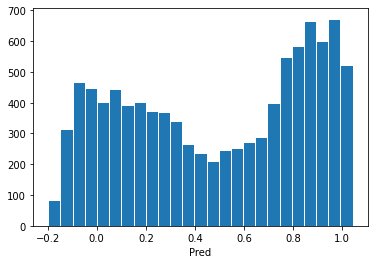

In [ ]:
plt.hist(submit.label,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [ ]:
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup= submit[submit["id"].isin(dup_test_ids)]  
sub_dup2= submit2[submit2["id"].isin(dup_test_ids)] 

In [ ]:
T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup,how='left',on='id').merge(sub_dup2,how='left',on='id')
T

,train id,true label,id,state_x,label_x,state_y,label_y
0,train_01463,1,test_01704,1,0.930551,1,0.930551
1,train_06891,1,test_03707,1,0.911571,1,0.911571
2,train_08302,1,test_04353,1,0.754567,1,0.754567
3,train_04506,1,test_04453,1,1.017384,1,1.017384
4,train_09470,0,test_04645,1,0.563731,1,0.563731
5,train_02156,1,test_06909,1,0.643583,1,0.643583
6,train_00365,0,test_08232,1,0.425497,0,0.425497
